# Introduction

### Objective:
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

### Goals:
Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Initialization

In [1]:
#Load Libraries Here
import time
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics  import f1_score, mean_squared_error, r2_score

# Load Data

In [2]:
#Load Data Here
df = pd.read_csv('/datasets/car_data.csv')

During the data pre-processing phase, the 'usual' was executed from getting a glimpse of what the data reveals (missing values, shape, dtypes, etc) to manipulating the data (dropping, renaming, and separting by numerical or categorical).

## Data preparation

In [3]:
df.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [4]:
df.shape

(354369, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
df.duplicated().sum()

262

In [8]:
nan_percent = {}

for x in df.columns:
    nan_pct = df[x].isnull().sum() / len(df) * 100
    if nan_pct > 0:
        nan_percent[x] = nan_pct

nan_percent_df = pd.DataFrame(list(nan_percent.items()), columns=['Column', 'Missing Percentage'])
print(nan_percent_df)

        Column  Missing Percentage
0  VehicleType           10.579368
1      Gearbox            5.596709
2        Model            5.560588
3     FuelType            9.282697
4  NotRepaired           20.079070


In [9]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [10]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [11]:
df['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [12]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
#update value here
df['VehicleType'] = df['VehicleType'].fillna('sedan')
df['Gearbox'] = df['Gearbox'].fillna('auto')
df['Model'] = df['Model'].fillna('other')
df['FuelType'] = df['FuelType'].fillna('petrol')
df['NotRepaired'] = df['NotRepaired'].fillna('no')

I went ahead and fill any of the column's missing values with the most common or sensible value in order to curate an evenly shaped dataframe. 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [16]:
mldf = df.drop(df[['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']], axis=1)

In [17]:
mldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [18]:
mldf.rename(columns={'Price' : 'price', 'VehicleType' : 'vehicletype',
                    'RegistrationYear' : 'registrationyear', 'Gearbox' : 'gearbox',
            'Power' : 'power', 'Model' : 'model',
            'Mileage' : 'mileage', 'RegistrationMonth' : 'registrationmonth',
            'FuelType' : 'fueltype', 'Brand' : 'brand',
            'NotRepaired' : 'notrepaired'}, inplace=True)

In [19]:
mldf.sample(10)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
221560,8800,wagon,2011,manual,165,zafira,30000,12,gasoline,opel,no
98519,5000,small,1990,manual,0,golf,20000,6,petrol,volkswagen,no
259891,7699,sedan,2002,auto,170,3er,150000,8,petrol,bmw,no
301998,3599,bus,2002,manual,125,zafira,150000,12,petrol,opel,yes
184621,7190,wagon,2007,manual,143,3er,150000,9,gasoline,bmw,no
304810,3200,convertible,2003,auto,61,roadster,125000,4,petrol,smart,no
152093,2300,wagon,2003,manual,131,passat,150000,12,gasoline,volkswagen,no
99269,3400,small,2005,auto,90,musa,100000,7,petrol,lancia,no
301175,900,small,1991,manual,45,polo,70000,4,petrol,volkswagen,no
121508,3200,bus,2003,manual,110,verso,150000,8,petrol,toyota,no


Here I separated the columns into 2 overall types, numerical and categorical, so that way it's easier to explore the data in its subset in the EDA phase.

In [20]:
#categorical
cmldf = mldf[['vehicletype','gearbox','model','fueltype','brand','notrepaired']]
cmldf

,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,sedan,manual,golf,petrol,volkswagen,no
1,coupe,manual,other,gasoline,audi,yes
2,suv,auto,grand,gasoline,jeep,no
3,small,manual,golf,petrol,volkswagen,no
4,small,manual,fabia,gasoline,skoda,no
...,...,...,...,...,...,...
354364,sedan,manual,colt,petrol,mitsubishi,yes
354365,sedan,auto,other,petrol,sonstige_autos,no
354366,convertible,auto,fortwo,petrol,smart,no
354367,bus,manual,transporter,gasoline,volkswagen,no


In [21]:
#numerical
nmldf = mldf[['price','registrationyear','power','mileage','registrationmonth']]
nmldf

,price,registrationyear,power,mileage,registrationmonth
0,480,1993,0,150000,0
1,18300,2011,190,125000,5
2,9800,2004,163,125000,8
3,1500,2001,75,150000,6
4,3600,2008,69,90000,7
...,...,...,...,...,...
354364,0,2005,0,150000,7
354365,2200,2005,0,20000,1
354366,1199,2000,101,125000,3
354367,9200,1996,102,150000,3


# EDA

I started with a correlation matrix heat map to see what relationships does the numerical data have with one another.

<AxesSubplot:>

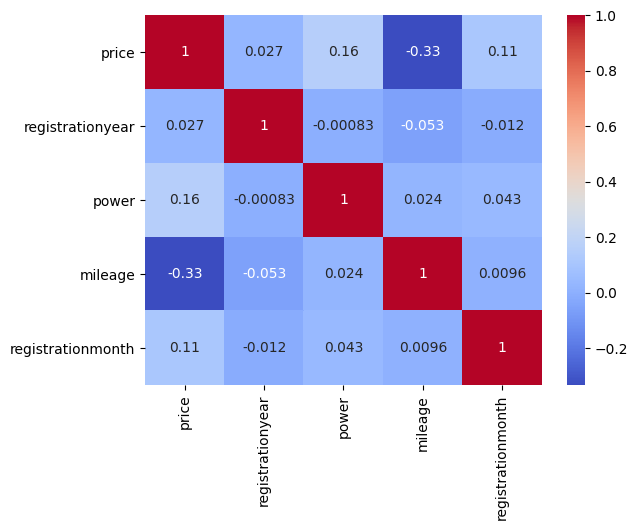

In [22]:
corr_matrix = mldf.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

So to my surprised everything, in terms of numerical values, has little to no significant correlation with one another. But as for the two columns - Price & (Horse)Power - relationship, there's a pretty decent and expected expectation that most common, daily cars aren't even hitting 1250 horsepower and there's an abundance of them at any price range.

<AxesSubplot:xlabel='price', ylabel='power'>

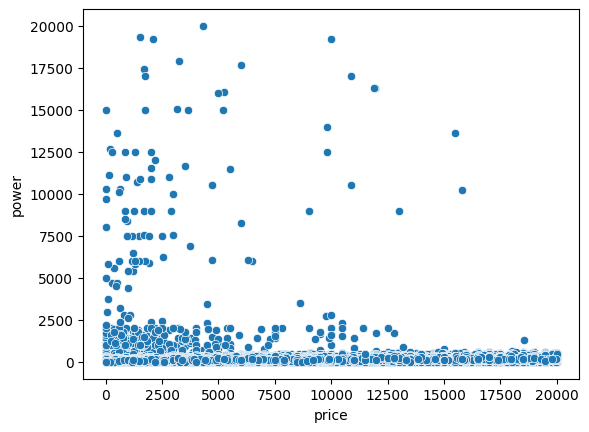

In [23]:
sns.scatterplot(x='price', y='power', data=mldf)

Overall when looking at the *Mile vs Price* boxplots dynamic, as mileage increases, their (median) price goes down - so high mileage vehicles tend to have lower prices - and while on the same token, but in terms of outliers, it shows that (100k+) high-mileage vehicles has several outliers on the higher end of the price spectrum (i.e. negatively skewed). And as for lower-mileage vehicles, let's say around 40-50k miles or less, are slightly positiviely skewed or somewhat symmetrical.

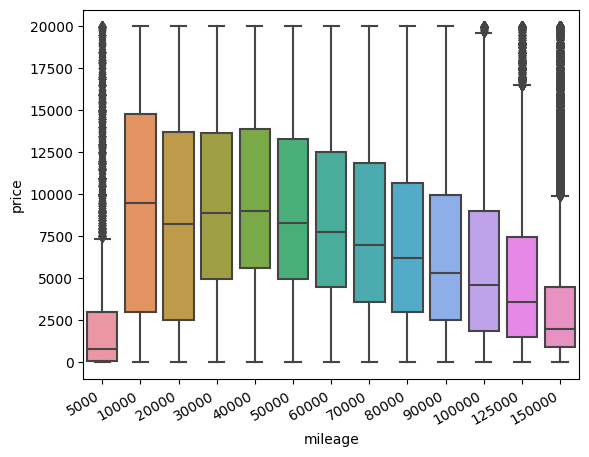

In [24]:
sns.boxplot(x='mileage', y='price', data=mldf)
plt.xticks(rotation=30, ha='right')
plt.show()

Right off the bat when looking at the Price's histogram plot, there's a right/positive skewness where we can see that most cars are cheaper or on the lower end of prices and as prices increase the fewer the cars. We can also see the histogram's peak so more or less, its safe to guess that most cars are priced between 2k - 2.5k; as for its drop off, its drastically seen around the 5k price mark.

<AxesSubplot:xlabel='price', ylabel='Count'>

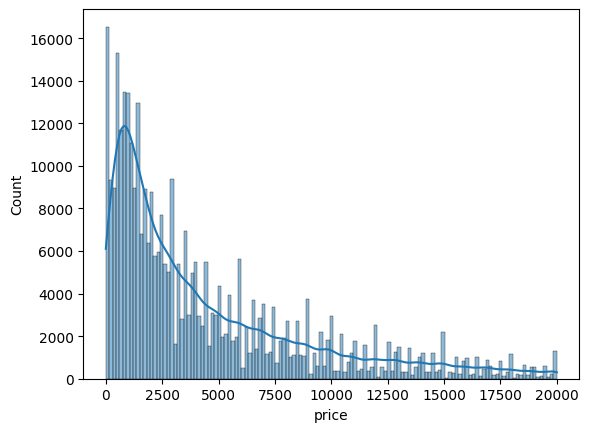

In [25]:
sns.histplot(nmldf['price'], kde=True)

Sedans, small and wagon type of cars are dominating the historical data with Sedans being the people's common choice of vehicle on top. Therefore individuals that are curious about their vehicle market value but have options like a convertible, coupe or suv have more or less half of the pool of options to determined their cars' value compared to the beforementioned invidivuals can grasp from.

<AxesSubplot:>

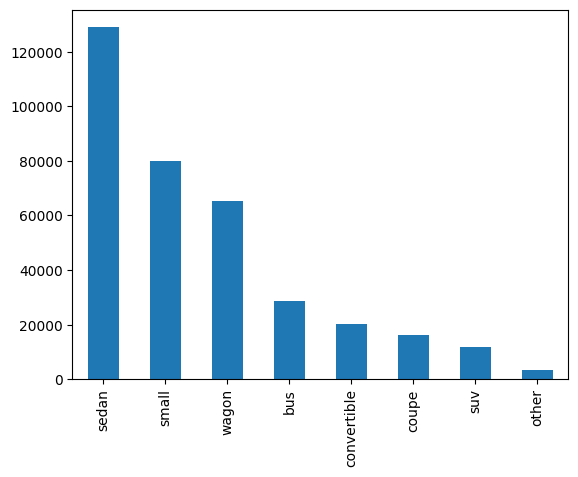

In [26]:
cmldf['vehicletype'].value_counts().plot(kind='bar')

About 88% of cars haven't been repaired at the time of input of historical data, which leaves about 11% who has been repaired.

In [27]:
cmldf['notrepaired'].value_counts().sum()

354369

In [28]:
cmldf['notrepaired'].value_counts()

no     318315
yes     36054
Name: notrepaired, dtype: int64

<AxesSubplot:>

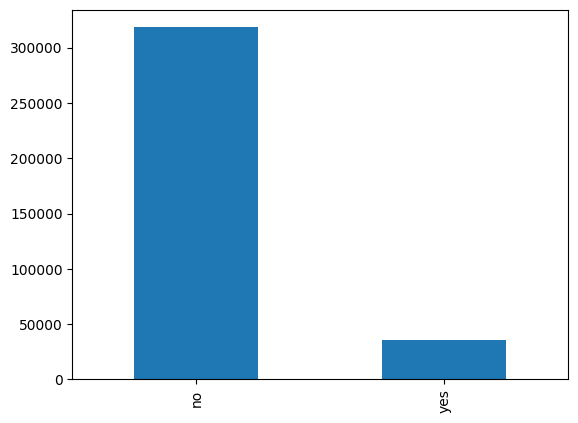

In [29]:
cmldf['notrepaired'].value_counts().plot(kind='bar')

This gives an overall insight of all the car brands' quantity from greatest to least clearly showing a abundance for Volks (but in tow, BMW and Opel) and brands such as Rover, Trabant & Lada with about less than 5k cars, respectfully, in comparison.

<AxesSubplot:>

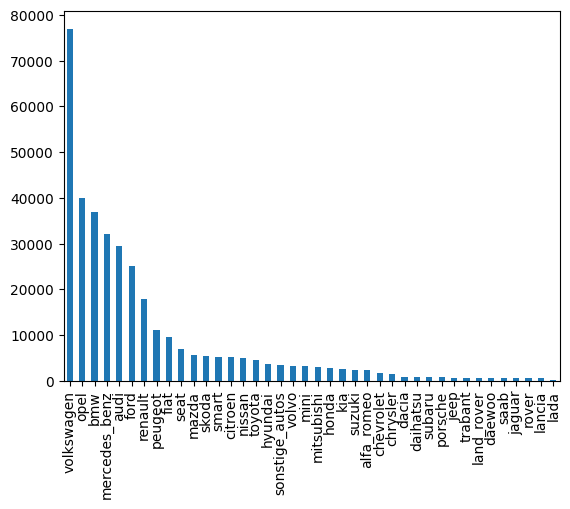

In [30]:
cmldf['brand'].value_counts().plot(kind='bar')

For a more closer insight, I narrowed down to the top 10 brands and their quantities.

In [31]:
brand = cmldf['brand'].value_counts()
top10 = brand.nlargest(10)
print(top10)

volkswagen       77013
opel             39931
bmw              36914
mercedes_benz    32046
audi             29456
ford             25179
renault          17927
peugeot          10998
fiat              9643
seat              6907
Name: brand, dtype: int64


When analyzing the top 10 car brands, there's a clear understanding that there's a large presence of outliers within each brand as these are where the higher priced vehicles reside. But the median prices do vary across the top 10 because luxury name brands like Mercedes-Benz, BMW and Audi clearly have higher median prices compared to Peugeot, Renault, Fiat or even Opel. Though most brands showcase a slight positive skewness that's shown through the longer tails on the higher pricing side.

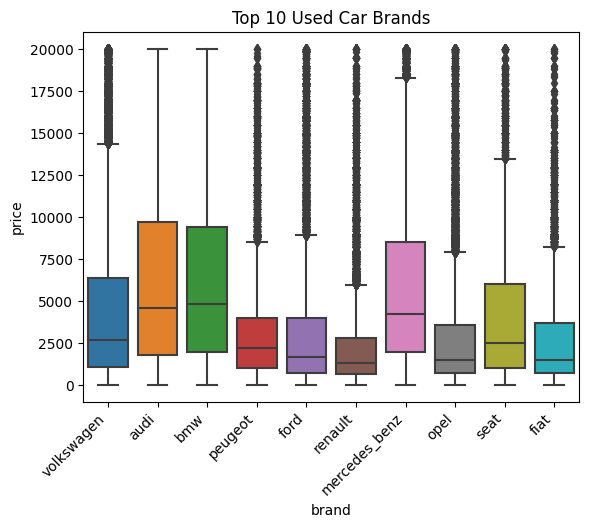

In [32]:
top10_df = mldf[mldf['brand'].isin(top10.index)]

sns.boxplot(x='brand', y='price', data=top10_df)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Used Car Brands')
plt.show()

## Model training

The refined dataset is split into train, validation, and test and their respective features & target shapes are printed.

In [33]:
x_train, x_temp, y_train, y_temp = train_test_split(mldf.drop('price', axis=1), mldf['price'], test_size=0.60, random_state=12345)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.45, random_state=12345)

# Print shapes to verify the splits
print(f'Train features shape: {x_train.shape}')
print(f'Train target shape: {y_train.shape} \n')
print(f'Validation features shape: {x_valid.shape}')
print(f'Validation target shape: {y_valid.shape} \n')
print(f'Test features shape: {x_test.shape}')
print(f'Test target shape: {y_test.shape}')

Train features shape: (141747, 10)
Train target shape: (141747,) 

Validation features shape: (116942, 10)
Validation target shape: (116942,) 

Test features shape: (95680, 10)
Test target shape: (95680,)


I ensured, since we're juggling with several algorithms, that the features within each set were encoded, scaled and aligned as not all algorithms need their features to be scaled or can directly handle categorical features when stated.

In [34]:
categorical_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
encoder.fit(x_train[categorical_features])

OneHotEncoder(handle_unknown='ignore')

In [35]:
# Data is transformed here
x_train_encoded = encoder.transform(x_train[categorical_features])
x_valid_encoded = encoder.transform(x_valid[categorical_features])
x_test_encoded = encoder.transform(x_test[categorical_features])

In [36]:
# I dropped the original categorical columns and resetted the index
x_train_non_cat = x_train.drop(columns=categorical_features).reset_index(drop=True)
x_valid_non_cat = x_valid.drop(columns=categorical_features).reset_index(drop=True)
x_test_non_cat = x_test.drop(columns=categorical_features).reset_index(drop=True)

In [37]:
# Then the DF is then converted into arrays
x_train_non_cat_array = x_train_non_cat.values
x_valid_non_cat_array = x_valid_non_cat.values
x_test_non_cat_array = x_test_non_cat.values

In [38]:
# then following the DF conversion I converted over the arrays into sparse matrices in order to deal with the abudance of 0s
x_train_non_cat_sparse = csr_matrix(x_train_non_cat_array)
x_valid_non_cat_sparse = csr_matrix(x_valid_non_cat_array)
x_test_non_cat_sparse = csr_matrix(x_test_non_cat_array)

In [39]:
# Following the final conversion, I then merged the matrices
x_train_combined_sparse = hstack([x_train_non_cat_sparse, x_train_encoded])
x_valid_combined_sparse = hstack([x_valid_non_cat_sparse, x_valid_encoded])
x_test_combined_sparse = hstack([x_test_non_cat_sparse, x_test_encoded])

In [40]:
# In order to avoid, Dtypes and sizing errors, I made sure their shapes are consistent
print(f'x_train_combined_sparse shape: {x_train_combined_sparse.shape}')
print(f'x_valid_combined_sparse shape: {x_valid_combined_sparse.shape}')
print(f'x_test_combined_sparse shape: {x_test_combined_sparse.shape}')

x_train_combined_sparse shape: (141747, 313)
x_valid_combined_sparse shape: (116942, 313)
x_test_combined_sparse shape: (95680, 313)


In [41]:
# then once I successfuly made sure the shapes are consistent
# and given how large the data had expanded I used the PCA method
# to deal with the large number of features/dimensionality reduction
# so I can compute my cells without the kernel crashing

pca = PCA(n_components=10)
x_train_reduced = pca.fit_transform(x_train_combined_sparse.toarray())
x_valid_reduced = pca.transform(x_valid_combined_sparse.toarray())
x_test_reduced = pca.transform(x_test_combined_sparse.toarray())

In [42]:
# I made sure the shapes are still accurate yet reduced to its original feature quantity
print(f'x_train_reduced shape: {x_train_reduced.shape}')
print(f'x_valid_reduced shape: {x_valid_reduced.shape}')
print(f'x_test_reduced shape: {x_test_reduced.shape}')

x_train_reduced shape: (141747, 10)
x_valid_reduced shape: (116942, 10)
x_test_reduced shape: (95680, 10)


In [43]:
#lastly scaled the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reduced)
x_valid_scaled = scaler.transform(x_valid_reduced)
x_test_scaled = scaler.transform(x_test_reduced)

### Linear Regression

This has these *3rd highest RMSE* so clearly this wasn't going to be as accurate compared to the other models given it was a baseline model, despite its training time is a being the fastest.

In [44]:
# Train the Linear Regression model
lr_model = LinearRegression()

start_time = time.time()
lr_model.fit(x_train_scaled, y_train)
fit_time = time.time() - start_time


# Predict and evaluate
start_time = time.time()
y_pred_lr = lr_model.predict(x_valid_scaled)
predict_time = time.time() - start_time

rmse_lr = np.sqrt(mean_squared_error(y_valid, y_pred_lr))
print(f'Linear Regression RMSE: {rmse_lr}')
print(f'Fit time: {fit_time} seconds')
print(f'Predict time: {predict_time} seconds')

Linear Regression RMSE: 3719.98941115333
Fit time: 0.06040167808532715 seconds
Predict time: 0.003915309906005859 seconds


### Random Forest

While this model has the *worse* RMSE score, this model did pretty well compared to other algorithms in terms of fit (2nd place) and predict time (1st place) but that leaves more room to question if it really tried to get to know the data's underlying relationships.

In [45]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=4, max_features=4)

# Train and evaluate
start_time = time.time()
rf_model.fit(x_train_encoded, y_train)
fit_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rf_model.predict(x_valid_encoded)
predict_time = time.time() - start_time

rmse_rf = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Fit time: {fit_time} seconds')
print(f'Predict time: {predict_time} seconds')

Random Forest RMSE: 4411.602848902514
Fit time: 0.3008763790130615 seconds
Predict time: 0.03849649429321289 seconds


### Light Gradient Boosting

This model has the *2nd best RMSE score* and this also speaks for its performance in terms of the training set's prediciton accuracy and timing.

In [46]:
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse',
    num_leaves=12, learning_rate=0.1, n_estimators=100)


start_time = time.time()
lgb_model.fit(x_train_encoded, y_train, eval_set=[(x_valid_encoded, y_valid)],
    early_stopping_rounds=10, verbose=100)
fit_time = time.time() - start_time

start_time = time.time()
y_pred_lgb = lgb_model.predict(x_valid_encoded, num_iteration=lgb_model.best_iteration_)
predict_time = time.time() - start_time

rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_pred_lgb))
print(f'LightGBM RMSE: {rmse_lgb}')
print(f'Fit time: {fit_time} seconds')
print(f'Predict time: {predict_time} seconds')

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 3628.7
LightGBM RMSE: 3628.699034403202
Fit time: 4.230376482009888 seconds
Predict time: 0.824857234954834 seconds


### XGBoost

Now XGBoost, had the *2nd worst and highest performing RMSE* in terms of training model accuracy of 4045, and its fit time took 42 seconds while its prediction timing on the validation merely took 0.1 second.

In [47]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=4)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

start_time = time.time()
grid_search.fit(x_train_encoded, y_train)
fit_time = time.time() - start_time

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


start_time = time.time()
y_pred_xgb = best_model.predict(x_valid_encoded)
predict_time = time.time() - start_time
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f'XGBoost Validation RMSE: {rmse_xgb}')
print(f'Best Parameters: {best_params}\n')
print(f'Fit time: {fit_time} seconds''\n')
print(f'Predict time: {predict_time} seconds')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
XGBoost Validation RMSE: 4045.771535168859
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1.0}

Fit time: 43.67815375328064 seconds

Predict time: 0.09575819969177246 seconds


### CatBoost

This model showed a pretty decent performance with it having *the lowest RMSE* while LightGBM is slightly behind with a 1,175 difference higher than Cat, it also did show the slowest fit training time compared to the algorithms being tested.

In [48]:
categorical_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

categorical_feature_indices = [x_train.columns.get_loc(col) for col in categorical_features]

param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.3],
    'iterations': [4, 6],
    'l2_leaf_reg': [3, 5],
    'border_count': [4, 6]}

cat_model = CatBoostRegressor(silent=True, cat_features=categorical_feature_indices)
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

start_time = time.time()
grid_search.fit(x_train, y_train)
fit_time = time.time() - start_time

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

start_time = time.time()
y_pred_cat = best_model.predict(x_valid)
predict_time = time.time() - start_time

rmse_cat = np.sqrt(mean_squared_error(y_valid, y_pred_cat))
print(f'CatBoost RMSE: {rmse_cat}')
print(f'Best Parameters: {best_params}')
print(f'Fit time: {fit_time} seconds')
print(f'Predict time: {predict_time} seconds')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
CatBoost RMSE: 2544.967569630192
Best Parameters: {'border_count': 6, 'depth': 6, 'iterations': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
Fit time: 62.19339871406555 seconds
Predict time: 0.18839240074157715 seconds


## Model analysis -- LGBM

The output of the LGBM showcases that it actually outpeformed most models, outside of CatBoost, but its training self by just a 0.66 point difference and huge difference in training time from about 0.800 seconds to just about 0.600 seconds, just by shaving off about 0.170 ms off.

In [49]:
start_time = time.time()
y_pred_lgb_test = lgb_model.predict(x_test_encoded, num_iteration=lgb_model.best_iteration_)
predict_time = time.time() - start_time

rmse_lgb_test = np.sqrt(mean_squared_error(y_test, y_pred_lgb_test))
print(f'LightGBM Test RMSE: {rmse_lgb_test}')
print(f'Predict time: {predict_time} seconds')

LightGBM Test RMSE: 3628.047721665831
Predict time: 0.6304512023925781 seconds


# Conclusion

To be honest, learning about supervised ML and its intricacies (within this sprint/project), trying to read and comprehend the LightGBM library, cross referencing prior projects and resources really shows how beautifully complex data can paint and showcase your findings. And although, not everything is exciting to read up but I still enjoyed it while realizing this (ML) isn't for the weak. There was a lot of trial and error I went through that doesn't obviously show itself in the final draft version(s) upon submission but what I want to conclude with is...

I choose the **Light GBM** model over the **CatBoost** model because overall, it had a better balance of *speed and accuracy* given how long it took the CatBoost model speed to conclude its results.Futhermore, the Light GBM has the second lowest RMSE on both the training & test with decently efficient training time. Now although the LR model was more a baseline model in this project, the 2nd best model was CatBoost with a slightly lower  RMSE and the 3rd and 4th placed models were XGBoost & Random Forest given they had sigificantly higher RMSE values thus implying poor model performance.